1. Data Preparation
- Phan tich tinh hinh covid

In [3]:
#Import packages
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf 
from tensorflow.keras import models,layers,losses,metrics,callbacks 


2023-05-08 14:23:52.082224: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-08 14:23:53.668572: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(array([-10.,   0.,  10.,  20.,  30.,  40.,  50.]),
 [Text(-10.0, 0, '2020-03-01'),
  Text(0.0, 0, '2020-01-24'),
  Text(10.0, 0, '2020-02-03'),
  Text(20.0, 0, '2020-02-13'),
  Text(30.0, 0, '2020-02-23'),
  Text(40.0, 0, '2020-03-04'),
  Text(50.0, 0, '')])

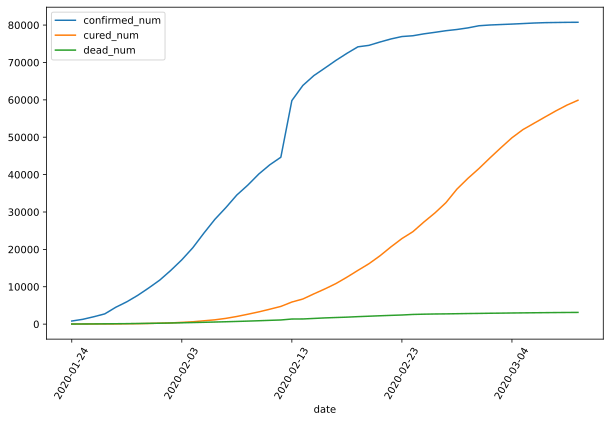

In [6]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

df = pd.read_csv("./data/covid-19.csv",sep = "\t")
df.plot(x = "date",y = ["confirmed_num","cured_num","dead_num"],figsize=(10,6))
plt.xticks(rotation=60)


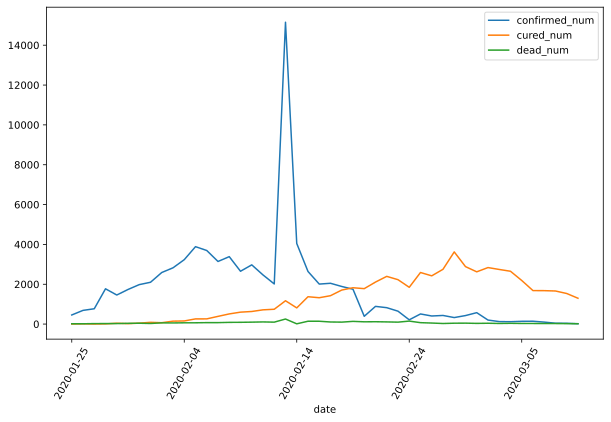

In [7]:
dfdata = df.set_index("date")
dfdiff = dfdata.diff(periods=1).dropna()
dfdiff = dfdiff.reset_index("date")

dfdiff.plot(x = "date",y = ["confirmed_num","cured_num","dead_num"],figsize=(10,6))
plt.xticks(rotation=60)
dfdiff = dfdiff.drop("date",axis = 1).astype("float32")


In [8]:
#Use the data of an eight-day window priorier of the date we are investigating as input for prediction
WINDOW_SIZE = 8

def batch_dataset(dataset):
    dataset_batched = dataset.batch(WINDOW_SIZE,drop_remainder=True)
    return dataset_batched

ds_data = tf.data.Dataset.from_tensor_slices(tf.constant(dfdiff.values,dtype = tf.float32)) \
   .window(WINDOW_SIZE,shift=1).flat_map(batch_dataset)

ds_label = tf.data.Dataset.from_tensor_slices(
    tf.constant(dfdiff.values[WINDOW_SIZE:],dtype = tf.float32))

#We put all data into one batch for better efficiency since the data volume is small.
ds_train = tf.data.Dataset.zip((ds_data,ds_label)).batch(38).cache()



2023-05-08 14:58:05.915317: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-08 14:58:06.207048: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-08 14:58:06.207142: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-08 14:58:06.222022: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-08 14:58:06.222113: I tensorflow/compile

2. Model Definition

In [11]:
#We design the following block since the daily increment of confirmed, discharged and deceased cases are equal or larger than zero.
class Block(layers.Layer):
    def __init__(self, **kwargs):
        super(Block, self).__init__(**kwargs)
    
    def call(self, x_input,x):
        x_out = tf.maximum((1+x)*x_input[:,-1,:],0.0)
        return x_out
    
    def get_config(self):  
        config = super(Block, self).get_config()
        return config


In [12]:
tf.keras.backend.clear_session()
x_input = layers.Input(shape = (None,3),dtype = tf.float32)
x = layers.LSTM(3,return_sequences = True,input_shape=(None,3))(x_input)
x = layers.LSTM(3,return_sequences = True,input_shape=(None,3))(x)
x = layers.LSTM(3,return_sequences = True,input_shape=(None,3))(x)
x = layers.LSTM(3,input_shape=(None,3))(x)
x = layers.Dense(3)(x)

#We design the following block since the daily increment of confirmed, discharged and deseased cases are equal or larger than zero.
#x = tf.maximum((1+x)*x_input[:,-1,:],0.0)
x = Block()(x_input,x)
model = models.Model(inputs = [x_input],outputs = [x])
model.summary()


2023-05-08 15:01:51.697281: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-08 15:01:51.699056: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-08 15:01:51.700188: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, 3)]    0           []                               
                                                                                                  
 lstm (LSTM)                    (None, None, 3)      84          ['input_1[0][0]']                
                                                                                                  
 lstm_1 (LSTM)                  (None, None, 3)      84          ['lstm[0][0]']                   
                                                                                                  
 lstm_2 (LSTM)                  (None, None, 3)      84          ['lstm_1[0][0]']                 
                                                                                              

2023-05-08 15:01:51.964504: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-08 15:01:51.966119: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-08 15:01:51.967114: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

3. Model Training

In [13]:
#Customized loss function, consider the ratio between square error and the prediction
class MSPE(losses.Loss):
    def call(self,y_true,y_pred):
        err_percent = (y_true - y_pred)**2/(tf.maximum(y_true**2,1e-7))
        mean_err_percent = tf.reduce_mean(err_percent)
        return mean_err_percent
    
    def get_config(self):
        config = super(MSPE, self).get_config()
        return config


In [14]:
import os
import datetime

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=optimizer,loss=MSPE(name = "MSPE"))

stamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
logdir = os.path.join('data', 'autograph', stamp)

## We recommend using pathlib under Python3
# from pathlib import Path
# stamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# logdir = str(Path('../data/autograph/' + stamp))

tb_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
#Half the learning rate if loss is not improved after 100 epoches
lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor="loss",factor = 0.5, patience = 100)
#Stop training when loss is not improved after 200 epoches
stop_callback = tf.keras.callbacks.EarlyStopping(monitor = "loss", patience= 200)
callbacks_list = [tb_callback,lr_callback,stop_callback]

history = model.fit(ds_train,epochs=500,callbacks = callbacks_list)


Epoch 1/500


2023-05-08 15:21:03.210246: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype float and shape [38,3]
	 [[{{node Placeholder/_8}}]]
2023-05-08 15:21:03.210485: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [46,3]
	 [[{{node Placeholder/_0}}]]
2023-05-08 15:21:03.499479: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' wi

2023-05-08 15:21:06.891924: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-08 15:21:06.893832: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-08 15:21:06.894920: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 20s 20s/step - loss: 3.7720 - lr: 0.0100
Epoch 2/500
1/1 [==============================] - 0s 89ms/step - loss: 3.4404 - lr: 0.0100
Epoch 3/500
1/1 [==============================] - 0s 87ms/step - loss: 3.1465 - lr: 0.0100
Epoch 4/500
1/1 [==============================] - 0s 98ms/step - loss: 2.8728 - lr: 0.0100
Epoch 5/500
1/1 [==============================] - 0s 89ms/step - loss: 2.5544 - lr: 0.0100
Epoch 6/500
1/1 [==============================] - 0s 88ms/step - loss: 2.2977 - lr: 0.0100
Epoch 7/500
1/1 [==============================] - 0s 90ms/step - loss: 1.9894 - lr: 0.0100
Epoch 8/500
1/1 [==============================] - 0s 92ms/step - loss: 1.7343 - lr: 0.0100
Epoch 9/500
1/1 [==============================] - 0s 85ms/step - loss: 1.4799 - lr: 0.0100
Epoch 10/500
1/1 [==============================] - 0s 85ms/step - loss: 1.2301 - lr: 0.0100
Epoch 11/500
1/1 [==============================] - 0s 91ms/step - loss: 0.9482 - lr: 0.010

1/1 [==============================] - 0s 89ms/step - loss: 0.4449 - lr: 0.0100
Epoch 90/500
1/1 [==============================] - 0s 92ms/step - loss: 0.4449 - lr: 0.0100
Epoch 91/500
1/1 [==============================] - 0s 85ms/step - loss: 0.4448 - lr: 0.0100
Epoch 92/500
1/1 [==============================] - 0s 89ms/step - loss: 0.4448 - lr: 0.0100
Epoch 93/500
1/1 [==============================] - 0s 86ms/step - loss: 0.4448 - lr: 0.0100
Epoch 94/500
1/1 [==============================] - 0s 90ms/step - loss: 0.4447 - lr: 0.0100
Epoch 95/500
1/1 [==============================] - 0s 87ms/step - loss: 0.4446 - lr: 0.0100
Epoch 96/500
1/1 [==============================] - 0s 82ms/step - loss: 0.4446 - lr: 0.0100
Epoch 97/500
1/1 [==============================] - 0s 89ms/step - loss: 0.4445 - lr: 0.0100
Epoch 98/500
1/1 [==============================] - 0s 86ms/step - loss: 0.4445 - lr: 0.0100
Epoch 99/500
1/1 [==============================] - 0s 88ms/step - loss: 0.4444 - l

1/1 [==============================] - 0s 88ms/step - loss: 0.4380 - lr: 0.0050
Epoch 177/500
1/1 [==============================] - 0s 84ms/step - loss: 0.4379 - lr: 0.0050
Epoch 178/500
1/1 [==============================] - 0s 109ms/step - loss: 0.4378 - lr: 0.0050
Epoch 179/500
1/1 [==============================] - 0s 83ms/step - loss: 0.4377 - lr: 0.0050
Epoch 180/500
1/1 [==============================] - 0s 82ms/step - loss: 0.4376 - lr: 0.0050
Epoch 181/500
1/1 [==============================] - 0s 87ms/step - loss: 0.4375 - lr: 0.0050
Epoch 182/500
1/1 [==============================] - 0s 84ms/step - loss: 0.4374 - lr: 0.0050
Epoch 183/500
1/1 [==============================] - 0s 83ms/step - loss: 0.4373 - lr: 0.0050
Epoch 184/500
1/1 [==============================] - 0s 82ms/step - loss: 0.4371 - lr: 0.0050
Epoch 185/500
1/1 [==============================] - 0s 84ms/step - loss: 0.4370 - lr: 0.0050
Epoch 186/500
1/1 [==============================] - 0s 82ms/step - loss: